In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests

from env import github_token, github_username

import acquire_zach as az
import wrangle as w

import numpy as np
import pandas as pd

# acquire
from requests import get
from bs4 import BeautifulSoup
from time import sleep
import os

# prepare
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# explore
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# model
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image

# Acquire

In [2]:
df = pd.read_csv('google_readmes1020.csv').drop(columns="Unnamed: 0")

In [3]:
df.head(2)

,repo,language,readme_contents
0,google/ci_edit,Python,# What is ci_edit\n\nci_edit is a text editor....
1,google/bms-toolkit,Shell,# bms-toolkit\n\nToolkit for installing and cr...


# Explore

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1020 non-null   object
 1   language         983 non-null    object
 2   readme_contents  1005 non-null   object
dtypes: object(3)
memory usage: 24.0+ KB


In [5]:
df.isnull().sum()

repo                0
language           37
readme_contents    15
dtype: int64

In [6]:
df[df.language.isnull()]

,repo,language,readme_contents
15,google/transit,NaN,The repository contains specification to manip...
22,google/overcoming-conflicting-data,NaN,# Conflicting Data for Model Updates\n\nThis r...
46,google/deepdream,NaN,# deepdream\n\nThis repository contains IPytho...
56,google/skywater-pdk-libs-sky130_fd_pr,NaN,:lib:`sky130_fd_pr` - SKY130 Primitive Models ...
67,google/proto-quic,NaN,proto-quic is deprecated\n====================...
72,google/CTAP2-test-tool-corpus,NaN,"# <img alt=""Test Tool logo"" src=""docs/img/logo..."
101,google/healthcare-text-annotation,NaN,# Healthcare Text Annotation Guidelines\n\nMed...
153,google/or-models,NaN,# OR-Models\n\nThis repository contains a mode...
191,google/mlir-npcomp,NaN,# mlir-npcomp\n\nThis project has moved to the...
222,google/oss-vulnerability-guide,NaN,# Guide to coordinated vulnerability disclosur...


In [7]:
df[df.readme_contents.isnull()]

,repo,language,readme_contents
32,google/aistplusplus_dataset,JavaScript,NaN
138,google/google.github.io,HTML,NaN
154,google/file.dart,Dart,NaN
277,google/.github,NaN,NaN
378,google/certificate-transparency-rfcs,Python,NaN
413,google/aichoreographer,HTML,NaN
425,google/look-before-you-speak,HTML,NaN
470,google/jsontoken,Java,NaN
587,google/coursebuilder-core,Python,NaN
591,google/prochlo,C++,NaN


In [8]:
df.dropna(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 0 to 1019
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             969 non-null    object
 1   language         969 non-null    object
 2   readme_contents  969 non-null    object
dtypes: object(3)
memory usage: 30.3+ KB


In [10]:
df.isnull().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [11]:
df.language.value_counts()

Python              195
C++                 152
Go                  121
Java                 92
JavaScript           86
TypeScript           51
Dart                 39
C                    36
Jupyter Notebook     29
HTML                 26
Rust                 21
Shell                21
Kotlin               15
Objective-C          11
Haskell               7
Vim script            7
Verilog               7
Ruby                  6
Swift                 5
Starlark              4
Vue                   4
C#                    4
CSS                   4
MATLAB                4
PHP                   3
R                     3
Lean                  2
CMake                 2
Jsonnet               1
TeX                   1
PureBasic             1
PowerShell            1
Makefile              1
Emacs Lisp            1
Assembly              1
Roff                  1
HCL                   1
Groovy                1
Crystal               1
Common Lisp           1
Name: language, dtype: int64

<AxesSubplot:>

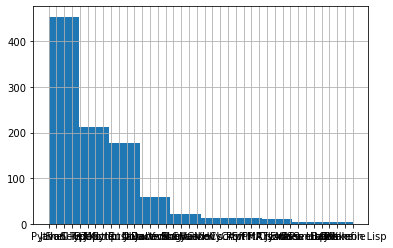

In [12]:
df.language.hist()

[Text(0.5, 1.0, 'Distribution of Google Coding Languages in Github Repos'),
 Text(0.5, 0, 'Number of Repos')]

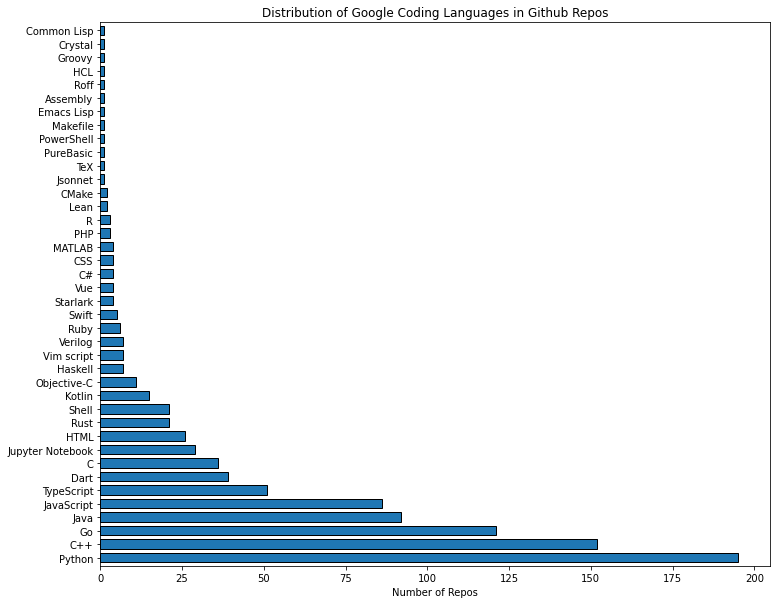

In [13]:
fig = plt.figure(figsize=(12, 10))

ax = df.language.value_counts().plot.barh(width=.7, ec='black')
plt.xticks(rotation=0)
ax.set(title='Distribution of Google Coding Languages in Github Repos', xlabel='Number of Repos')

In [14]:
len(df.readme_contents[0])

8384

In [15]:
length = []
for c in df.readme_contents:
    text_len = len(c)
    length.append(text_len)

length

[8384,
 2872,
 2198,
 4730,
 1869,
 3206,
 5079,
 218,
 2898,
 13752,
 998,
 3997,
 675,
 907,
 727,
 3189,
 4730,
 397,
 926,
 927,
 5090,
 9938,
 1958,
 703,
 2318,
 2933,
 7279,
 18254,
 1704,
 17228,
 2291,
 1949,
 11376,
 3147,
 1257,
 2254,
 2270,
 31458,
 292,
 5263,
 4914,
 4283,
 1513,
 2597,
 1957,
 216,
 16225,
 1421,
 4600,
 22596,
 1765,
 11797,
 12227,
 210,
 19,
 1499,
 9671,
 4078,
 4500,
 1339,
 2736,
 3910,
 6440,
 9670,
 1063,
 1843,
 856,
 4712,
 936,
 1167,
 275,
 8047,
 203,
 4345,
 651,
 2604,
 2180,
 981,
 1760,
 6290,
 2946,
 1963,
 5366,
 2131,
 983,
 4285,
 1031,
 4664,
 2598,
 2381,
 1204,
 43298,
 803,
 5784,
 287,
 5276,
 1173,
 727,
 1443,
 2668,
 16677,
 6431,
 2177,
 5071,
 2611,
 10275,
 2570,
 5839,
 24805,
 1258,
 538,
 932,
 299,
 3012,
 3067,
 2630,
 1953,
 15940,
 1675,
 4969,
 652,
 1853,
 2153,
 1885,
 474,
 2898,
 25076,
 2663,
 7635,
 2594,
 5712,
 24,
 4375,
 502,
 112,
 541,
 5862,
 2540,
 2322,
 497,
 4577,
 1435,
 10591,
 2560,
 1464,
 224

In [16]:
#def get_readme_length():
#    """
#    This function reads the length of each readme and
#    appends it to a list.
#    """
#    
#    length = []
#    for c in df.readme_contents:
#        text_len = len(c)
#        length.append(text_len)
#    
#    return length

In [17]:
def get_length(column):
    """
    This function reads the length of each readme and
    appends it to a list.
    """
    
    length = []
    for c in df[column]:
        text_len = len(c)
        length.append(text_len)
    
    return length

In [18]:
df['readme_length'] = get_length("readme_contents")

In [19]:
df.head(2)

,repo,language,readme_contents,readme_length
0,google/ci_edit,Python,# What is ci_edit\n\nci_edit is a text editor....,8384
1,google/bms-toolkit,Shell,# bms-toolkit\n\nToolkit for installing and cr...,2872


<AxesSubplot:>

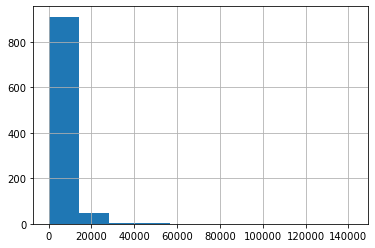

In [20]:
df.readme_length.hist()

In [21]:
df.readme_length.describe()

count       969.000000
mean       4919.704850
std        7116.134426
min          10.000000
25%        1363.000000
50%        2955.000000
75%        5946.000000
max      142109.000000
Name: readme_length, dtype: float64

<AxesSubplot:xlabel='readme_length'>

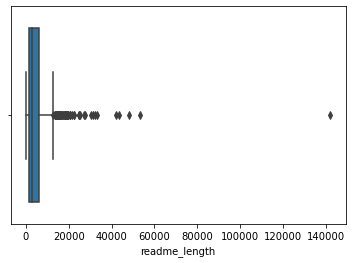

In [22]:
sns.boxplot(data=df, x='readme_length')

In [23]:
(df.readme_length > 120_000).sum()

1

In [24]:
df[df.readme_length > 120_000]

,repo,language,readme_contents,readme_length
650,google/corpuscrawler,Python,# Corpus Crawler\n\n_Corpus Crawler_ is a tool...,142109


In [25]:
df[df.readme_length > 20_000]

,repo,language,readme_contents,readme_length
40,google/glog,C++,Google Logging Library\n======================...,31458
53,google/AFL,C,# american fuzzy lop\n\n[![Build Status](https...,22596
98,google/seqio,Python,"# SeqIO: Task-based datasets, preprocessing, a...",43298
116,google/closure-stylesheets,Java,# Closure Stylesheets\n\nClosure Stylesheets i...,24805
134,google/data-layer-helper,JavaScript,# Data Layer Helper Library\nThis library prov...,25076
156,google/anthos-microk8s,HCL,![Anthos Config Management + Cloud Source Repo...,22477
181,google/stm32_bare_lib,C,# STM32 Bare Library\n\nSystem functions and e...,20784
204,google/basis_universal,C++,# Repository note\n\nThis repository is design...,24865
264,google/jax,Python,"<div align=""center"">\n<img src=""https://raw.gi...",21486
333,google/fscrypt,Go,# fscrypt [![GitHub version](https://badge.fur...,42259


In [26]:
df.repo.duplicated().value_counts()

False    969
Name: repo, dtype: int64

In [27]:
# transform into a series

string = " ".join(df.readme_contents)

string = " ".join(w.clean(string))

In [28]:
words = pd.Series(string.split())

# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
e,327020,0.111964,1.000000
t,236860,0.081095,0.724298
o,205583,0.070387,0.628656
i,204572,0.070041,0.625564
a,199362,0.068257,0.609632
r,187814,0.064303,0.574320
n,177020,0.060607,0.541312
s,174124,0.059616,0.532457
l,148936,0.050992,0.455434
c,138062,0.047269,0.422182


In [29]:
df['clean_content'] = df.readme_contents.apply(w.clean)

In [30]:
df.head(2)

,repo,language,readme_contents,readme_length,clean_content
0,google/ci_edit,Python,# What is ci_edit\n\nci_edit is a text editor....,8384,ci_edit ci_edit text editor help view edit tex...
1,google/bms-toolkit,Shell,# bms-toolkit\n\nToolkit for installing and cr...,2872,bmstoolkit toolkit installing creating initial...


In [31]:
df['cleaned_length'] = get_length("clean_content")

In [32]:
df.head(2)

,repo,language,readme_contents,readme_length,clean_content,cleaned_length
0,google/ci_edit,Python,# What is ci_edit\n\nci_edit is a text editor....,8384,ci_edit ci_edit text editor help view edit tex...,5408
1,google/bms-toolkit,Shell,# bms-toolkit\n\nToolkit for installing and cr...,2872,bmstoolkit toolkit installing creating initial...,1918


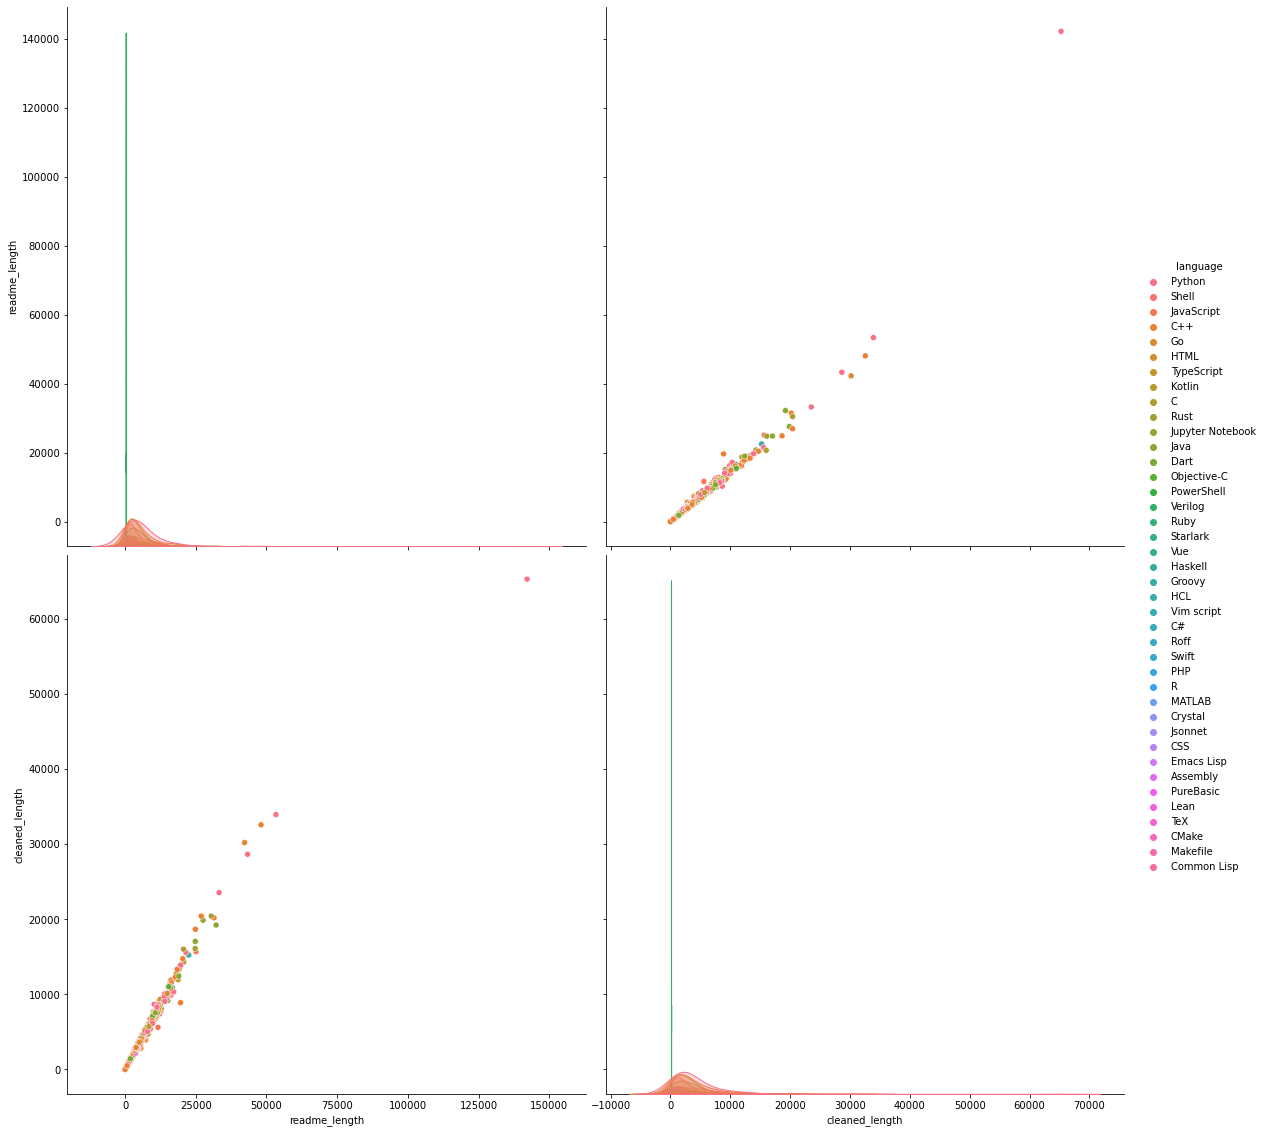

In [33]:
#fig, ax = plt.subplots(figsize=(20,20))
sns.pairplot(df, hue='language', height=8, aspect=1)

In [34]:
languages = (df.language.value_counts()).index.to_list()

In [35]:
re.sub(r'\s', '', languages[8].lower())

'jupyternotebook'

In [35]:
for language in languages:
    lang = re.sub(r'\s', '', language.lower())
    print(f'{lang}_words')
    

python_words
c++_words
go_words
java_words
javascript_words
typescript_words
dart_words
c_words
jupyternotebook_words
html_words
rust_words
shell_words
kotlin_words
objective-c_words
verilog_words
haskell_words
vimscript_words
ruby_words
swift_words
matlab_words
c#_words
vue_words
css_words
starlark_words
r_words
php_words
lean_words
cmake_words
jsonnet_words
roff_words
commonlisp_words
purebasic_words
tex_words
emacslisp_words
powershell_words
hcl_words
assembly_words
crystal_words
makefile_words
groovy_words


In [80]:
df.clean_content[0].split()

['ci_edit',
 'ci_edit',
 'text',
 'editor',
 'help',
 'view',
 'edit',
 'text',
 'file',
 'ci_edit',
 'run',
 'command',
 'line',
 'also',
 'called',
 'terminal',
 'start',
 'using',
 'ci_edit',
 'download',
 'ci_edit',
 'open',
 'execute',
 'cipy',
 'ci_edit',
 'many',
 'command',
 'line',
 'text',
 'editor',
 'require',
 'learning',
 'different',
 'set',
 'mouse',
 'keyboard',
 'command',
 'many',
 'u',
 'use',
 'graphical',
 'editor',
 'gui',
 'support',
 'common',
 'set',
 'command',
 'like',
 'ctrlq',
 'quit',
 'hold',
 'control',
 'key',
 'press',
 'q',
 'common',
 'command',
 'ctrlq',
 'quit',
 'program',
 'ctrls',
 'save',
 'file',
 'ctrlz',
 'undo',
 'ctrlx',
 'cut',
 'ctrlc',
 'copy',
 'ctrlv',
 'paste',
 'probably',
 'get',
 'idea',
 'common',
 'control',
 'common',
 'command',
 'line',
 'editor',
 'youd',
 'like',
 'edit',
 'file',
 'terminal',
 'window',
 'dont',
 'want',
 'recall',
 'save',
 'quit',
 'unfamiliar',
 'editor',
 'ci_edit',
 'shine',
 'ci_edit',
 'support',
 

In [36]:
df[df.language == 'Python'].clean_content

0       [ci_edit, ci_edit, text, editor, help, view, e...
4       [sa360, bigquery, bootstrapper, provides, supp...
30      [brain, tokyo, workshop, repo, contains, resea...
36      [fedjax, federated, learning, simulation, jax,...
42      [trimmed, match, robust, statistical, techniqu...
                              ...                        
1005    [aist, api, repo, contains, starter, code, usi...
1008    [next, repository, contains, code, model, foll...
1014    [vimdoc, helpfile, generation, vim, plugins, v...
1015    [shoptimizer, _copyright, 2019, google, llc, s...
1016    [vroom, launch, vim, test, vroomimagesvroom_lo...
Name: clean_content, Length: 195, dtype: object

In [36]:
def clean(text, extra_words = ['r', 'u', '2', 'ltgt', "'"]):
    """
    A simple function to cleanup text data:
    takes in a string of text,
    pulls in `nltk`s stopwords and appends any additional `extra_words`
    returns a string filtered for stopwords & lemmatized    
    """
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + extra_words
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [107]:
# create lists of labeled words

python_words = clean(' '.join(df[df.language == 'Python'].readme_contents))
cplusplus_words = clean(' '.join(df[df.language == 'C++'].readme_contents))
go_words = clean(' '.join(df[df.language == 'Go'].readme_contents))
java_words = clean(' '.join(df[df.language == 'Java'].readme_contents))
javascript_words = clean(' '.join(df[df.language == 'JavaScript'].readme_contents))
typescript_words = clean(' '.join(df[df.language == 'TypeScript'].readme_contents))
dart_words = clean(' '.join(df[df.language == 'Dart'].readme_contents))
c_words = clean(' '.join(df[df.language == 'C'].readme_contents))
jupyternotebook_words = clean(' '.join(df[df.language == 'Jupyter Notebook'].readme_contents))
html_words = clean(' '.join(df[df.language == 'HTML'].readme_contents))
shell_words = clean(' '.join(df[df.language == 'Shell'].readme_contents))
rust_words = clean(' '.join(df[df.language == 'Rust'].readme_contents))
kotlin_words = clean(' '.join(df[df.language == 'Kotlin'].readme_contents))
objective_c_words = clean(' '.join(df[df.language == 'Objective-C'].readme_contents))
verilog_words = clean(' '.join(df[df.language == 'Verilog'].readme_contents))
vimscript_words = clean(' '.join(df[df.language == 'Vim script'].readme_contents))
haskell_words = clean(' '.join(df[df.language == 'Haskell'].readme_contents))
ruby_words = clean(' '.join(df[df.language == 'Ruby'].readme_contents))
swift_words = clean(' '.join(df[df.language == 'Swift'].readme_contents))
vue_words = clean(' '.join(df[df.language == 'Vue'].readme_contents))
matlab_words = clean(' '.join(df[df.language == 'MATLAB'].readme_contents))
c_sharp_words = clean(' '.join(df[df.language == 'C#'].readme_contents))
starlark_words = clean(' '.join(df[df.language == 'Starlark'].readme_contents))
css_words = clean(' '.join(df[df.language == 'CSS'].readme_contents))
r_words = clean(' '.join(df[df.language == 'R'].readme_contents))
php_words = clean(' '.join(df[df.language == 'PHP'].readme_contents))
cmake_words = clean(' '.join(df[df.language == 'CMake'].readme_contents))
lean_words = clean(' '.join(df[df.language == 'Lean'].readme_contents))
jsonnet_words = clean(' '.join(df[df.language == 'Jsonnet'].readme_contents))
groovy_words = clean(' '.join(df[df.language == 'Groovy'].readme_contents))
assembly_words = clean(' '.join(df[df.language == 'Assembly'].readme_contents))
makefile_words = clean(' '.join(df[df.language == 'Makefile'].readme_contents))
crystal_words = clean(' '.join(df[df.language == 'Crystal'].readme_contents))
emacslisp_words = clean(' '.join(df[df.language == 'Emacs Lisp'].readme_contents))
commonlisp_words = clean(' '.join(df[df.language == 'Common Lisp'].readme_contents))
powershell_words = clean(' '.join(df[df.language == 'PowerShell'].readme_contents))
tex_words = clean(' '.join(df[df.language == 'TeX'].readme_contents))
roff_words = clean(' '.join(df[df.language == 'Roff'].readme_contents))
purebasic_words = clean(' '.join(df[df.language == 'PureBasic'].readme_contents))
hcl_words = clean(' '.join(df[df.language == 'HCL'].readme_contents))
all_words = clean(' '.join(df.readme_contents))

In [38]:
python_words

['ci_edit',
 'ci_edit',
 'text',
 'editor',
 'help',
 'view',
 'edit',
 'text',
 'file',
 'ci_edit',
 'run',
 'command',
 'line',
 'also',
 'called',
 'terminal',
 'start',
 'using',
 'ci_edit',
 'download',
 'ci_edit',
 'open',
 'execute',
 'cipy',
 'ci_edit',
 'many',
 'command',
 'line',
 'text',
 'editor',
 'require',
 'learning',
 'different',
 'set',
 'mouse',
 'keyboard',
 'command',
 'many',
 'u',
 'use',
 'graphical',
 'editor',
 'gui',
 'support',
 'common',
 'set',
 'command',
 'like',
 'ctrlq',
 'quit',
 'hold',
 'control',
 'key',
 'press',
 'q',
 'common',
 'command',
 'ctrlq',
 'quit',
 'program',
 'ctrls',
 'save',
 'file',
 'ctrlz',
 'undo',
 'ctrlx',
 'cut',
 'ctrlc',
 'copy',
 'ctrlv',
 'paste',
 'probably',
 'get',
 'idea',
 'common',
 'control',
 'common',
 'command',
 'line',
 'editor',
 'youd',
 'like',
 'edit',
 'file',
 'terminal',
 'window',
 'dont',
 'want',
 'recall',
 'save',
 'quit',
 'unfamiliar',
 'editor',
 'ci_edit',
 'shine',
 'ci_edit',
 'support',
 

In [108]:
# create a pd.Series of the value_counts of the list

python_freq = pd.Series(python_words).value_counts()
cplusplus_freq = pd.Series(cplusplus_words).value_counts()
go_freq = pd.Series(go_words).value_counts()
java_freq = pd.Series(java_words).value_counts()
javascript_freq = pd.Series(javascript_words).value_counts()
typescript_freq = pd.Series(typescript_words).value_counts()
dart_freq = pd.Series(dart_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
jupyternotebook_freq = pd.Series(jupyternotebook_words).value_counts()
html_freq = pd.Series(html_words).value_counts()
shell_freq = pd.Series(shell_words).value_counts()
rust_freq = pd.Series(rust_words).value_counts()
kotlin_freq = pd.Series(kotlin_words).value_counts()
objective_c_freq = pd.Series(objective_c_words).value_counts()
verilog_freq = pd.Series(verilog_words).value_counts()
vimscript_freq = pd.Series(vimscript_words).value_counts()
haskell_freq = pd.Series(haskell_words).value_counts()
ruby_freq = pd.Series(ruby_words).value_counts()
swift_freq = pd.Series(swift_words).value_counts()
vue_freq = pd.Series(vue_words).value_counts()
matlab_freq = pd.Series(matlab_words).value_counts()
c_sharp_freq = pd.Series(c_sharp_words).value_counts()
starlark_freq = pd.Series(starlark_words).value_counts()
css_freq = pd.Series(css_words).value_counts()
r_freq = pd.Series(r_words).value_counts()
php_freq = pd.Series(php_words).value_counts()
cmake_freq = pd.Series(cmake_words).value_counts()
lean_freq = pd.Series(lean_words).value_counts()
jsonnet_freq = pd.Series(jsonnet_words).value_counts()
groovy_freq = pd.Series(groovy_words).value_counts()
assembly_freq = pd.Series(assembly_words).value_counts()
makefile_freq = pd.Series(makefile_words).value_counts()
crystal_freq = pd.Series(crystal_words).value_counts()
emacslisp_freq = pd.Series(emacslisp_words).value_counts()
commonlisp_freq = pd.Series(commonlisp_words).value_counts()
powershell_freq = pd.Series(powershell_words).value_counts()
tex_freq = pd.Series(tex_words).value_counts()
roff_freq = pd.Series(roff_words).value_counts()
purebasic_freq = pd.Series(purebasic_words).value_counts()
hcl_freq = pd.Series(hcl_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [109]:
freq_list = [
    python_freq, 
    cplusplus_freq, 
    go_freq, 
    java_freq, 
    javascript_freq, 
    typescript_freq, 
    dart_freq, 
    c_freq, 
    jupyternotebook_freq, 
    html_freq, 
    shell_freq, 
    rust_freq, 
    kotlin_freq, 
    objective_c_freq, 
    verilog_freq, 
    vimscript_freq, 
    haskell_freq, 
    ruby_freq, 
    swift_freq, 
    vue_freq, 
    matlab_freq, 
    c_sharp_freq, 
    starlark_freq, 
    css_freq, 
    r_freq, 
    php_freq, 
    cmake_freq, 
    lean_freq, 
    jsonnet_freq, 
    groovy_freq, 
    assembly_freq, 
    makefile_freq, 
    crystal_freq, 
    emacslisp_freq, 
    commonlisp_freq, 
    powershell_freq, 
    tex_freq, 
    roff_freq, 
    purebasic_freq, 
    hcl_freq,
    all_freq
]

In [110]:
freq_list_str = [
    "python_freq", 
    "cplusplus_freq", 
    "go_freq", 
    "java_freq", 
    "javascript_freq", 
    "typescript_freq", 
    "dart_freq", 
    "c_freq", 
    "jupyternotebook_freq", 
    "html_freq", 
    "shell_freq", 
    "rust_freq", 
    "kotlin_freq", 
    "objective_c_freq", 
    "verilog_freq", 
    "vimscript_freq", 
    "haskell_freq", 
    "ruby_freq", 
    "swift_freq", 
    "vue_freq", 
    "matlab_freq", 
    "c_sharp_freq", 
    "starlark_freq", 
    "css_freq", 
    "r_freq", 
    "php_freq", 
    "cmake_freq", 
    "lean_freq", 
    "jsonnet_freq", 
    "groovy_freq", 
    "assembly_freq", 
    "makefile_freq", 
    "crystal_freq", 
    "emacslisp_freq", 
    "commonlisp_freq", 
    "powershell_freq", 
    "tex_freq", 
    "roff_freq", 
    "purebasic_freq", 
    "hcl_freq", 
    "all_freq"
]

In [114]:
lang_list_str = [
    "python", 
    "cplusplus", 
    "go", 
    "java", 
    "javascript", 
    "typescript", 
    "dart", 
    "c", 
    "jupyternotebook", 
    "html", 
    "shell", 
    "rust", 
    "kotlin", 
    "objective_c", 
    "verilog", 
    "vimscript", 
    "haskell", 
    "ruby", 
    "swift", 
    "vue", 
    "matlab", 
    "c_sharp", 
    "starlark", 
    "css", 
    "r", 
    "php", 
    "cmake", 
    "lean", 
    "jsonnet", 
    "groovy", 
    "assembly", 
    "makefile", 
    "crystal", 
    "emacslisp", 
    "commonlisp", 
    "powershell", 
    "tex", 
    "roff", 
    "purebasic", 
    "hcl", 
    "all"
]

In [115]:
# create a pd.DataFrame of the concated series of value_counts

word_counts = (pd.concat(freq_list, axis=1, sort=True)
                .set_axis(lang_list_str, axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [116]:
word_counts.head(2)

,python,cplusplus,go,java,javascript,typescript,dart,c,jupyternotebook,html,...,makefile,crystal,emacslisp,commonlisp,powershell,tex,roff,purebasic,hcl,all
0,119,125,60,27,34,7,3,33,16,0,...,0,5,0,0,0,0,0,0,0,457
00,12,10,1,1,0,0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,34


In [45]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head(20)

(20, 20)                   206
(pip, install)             117
(google, product)          101
(google, cloud)             96
(binding, spec)             61
(official, google)          59
(supported, google)         52
(officially, supported)     52
(make, sure)                50
(open, source)              50
(git, clone)                49
(python, import)            47
(service, account)          47
(neural, network)           44
(def, __init__self)         39
(arg, name)                 38
(0a, 20)                    36
(following, command)        35
(bash, python)              35
(codeblock, python)         34
dtype: int64

In [ ]:
top_5_languages = ["python_words", "cplusplus_words", "go_words", "java_words", "javascript_words"]

In [ ]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head(20)

In [46]:
#create a list of tuples in pd.Series index
top_20_python_tuplelist = top_20_python_bigrams.index.to_list()

In [47]:
#convert list of tuples to a list of all words in tuple list
top_20_python_list = [word for t in top_20_python_tuplelist for word in t]

(-0.5, 399.5, 199.5, -0.5)

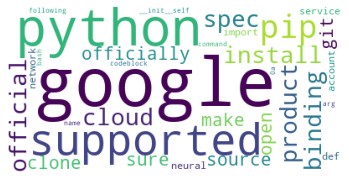

In [48]:
# use `' '.join()` to concat the list of spam words into a string to input

img = WordCloud(background_color='white').generate(' '.join(top_20_python_list))

# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)

# axis aren't very useful for a word cloud
plt.axis('off')

In [ ]:
top_20_ham_bigrams.sort_values().plot.barh(color='m', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1]) #handles the concatinating of the tuples
_ = plt.yticks(ticks, labels)

In [60]:
from PIL import Image
from wordcloud import ImageColorGenerator

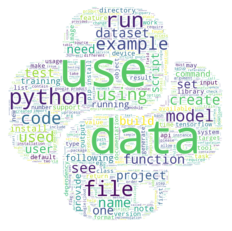

In [58]:
mask = np.array(Image.open("pythonimg.jpg"))
wc = WordCloud(mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc.generate(' '.join(python_words))

plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

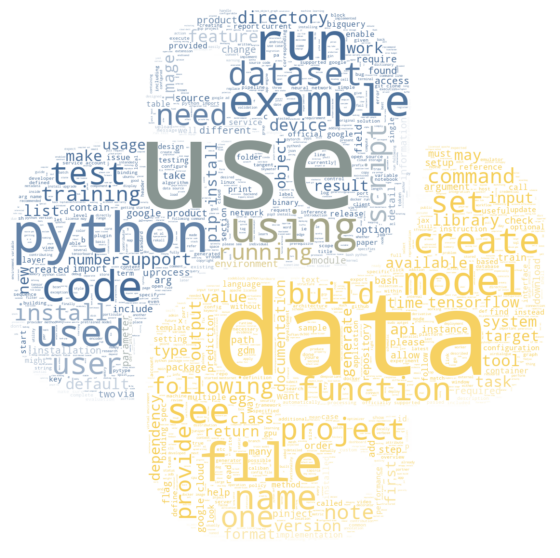

In [66]:
fig = plt.figure(figsize=(10, 10))

mask = np.array(Image.open("pythonimg.jpg"))
wc = WordCloud(mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc.generate(' '.join(python_words))

# create coloring from image
image_colors = ImageColorGenerator(mask)

plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')

plt.show()

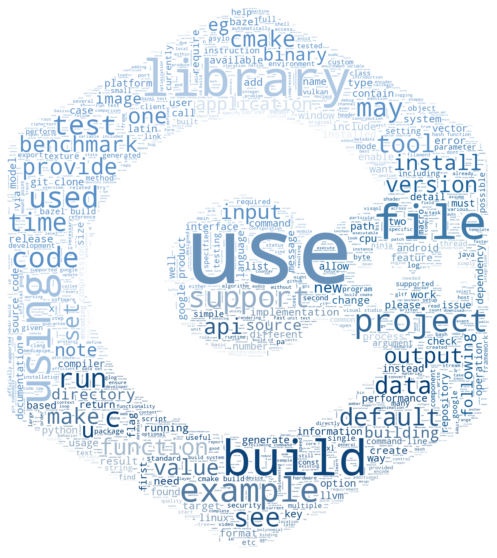

In [67]:
fig = plt.figure(figsize=(10, 10))

mask = np.array(Image.open("c++.jpg"))
wc = WordCloud(mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc.generate(' '.join(cplusplus_words))

# create coloring from image
image_colors = ImageColorGenerator(mask)

plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')

plt.show()

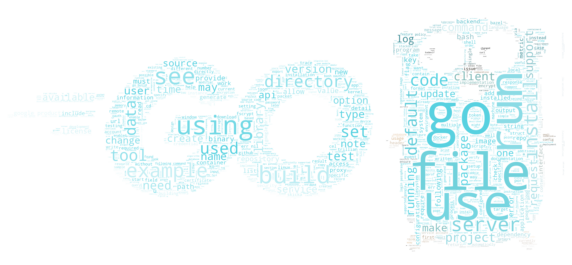

In [68]:
fig = plt.figure(figsize=(10, 10))

mask = np.array(Image.open("go.jpg"))
wc = WordCloud(mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc.generate(' '.join(go_words))

# create coloring from image
image_colors = ImageColorGenerator(mask)

plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')

plt.show()

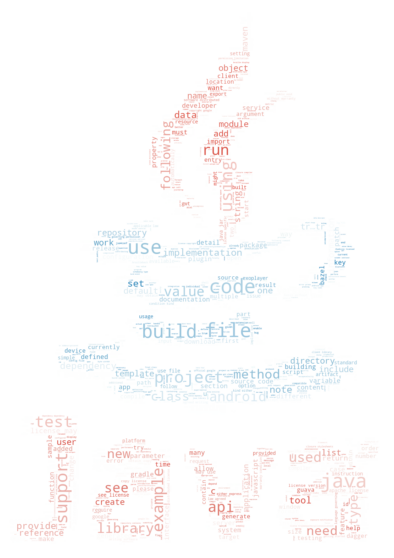

In [79]:
fig = plt.figure(figsize=(10, 10))

mask = np.array(Image.open("java.jpg"))
wc = WordCloud(mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc.generate(' '.join(java_words))

# create coloring from image
image_colors = ImageColorGenerator(mask)

plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')

plt.show()

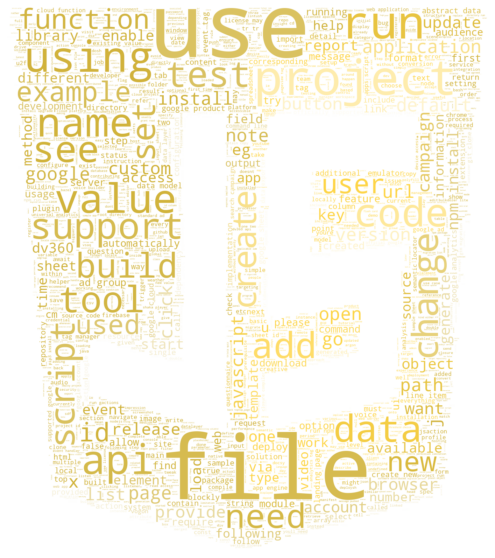

In [80]:
fig = plt.figure(figsize=(10, 10))

mask = np.array(Image.open("js.jpg"))
wc = WordCloud(mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc.generate(' '.join(javascript_words))

# create coloring from image
image_colors = ImageColorGenerator(mask)

plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')

plt.show()

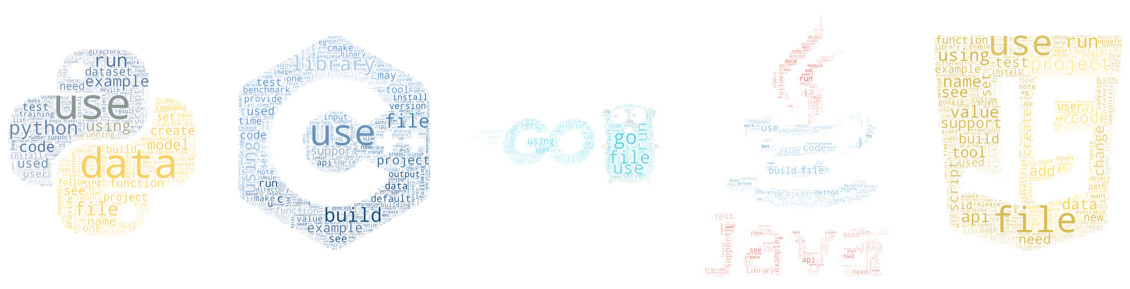

In [85]:
mask1 = np.array(Image.open("pythonimg.jpg"))
wc1 = WordCloud(mask=mask1, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc1.generate(' '.join(python_words))
image_colors1 = ImageColorGenerator(mask1)

mask2 = np.array(Image.open("c++.jpg"))
wc2 = WordCloud(mask=mask2, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc2.generate(' '.join(cplusplus_words))
image_colors2 = ImageColorGenerator(mask2)

mask3 = np.array(Image.open("go.jpg"))
wc3 = WordCloud(mask=mask3, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc3.generate(' '.join(go_words))
image_colors3 = ImageColorGenerator(mask3)

mask4 = np.array(Image.open("java.jpg"))
wc4 = WordCloud(mask=mask4, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc4.generate(' '.join(java_words))
image_colors4 = ImageColorGenerator(mask4)

mask5 = np.array(Image.open("js.jpg"))
wc5 = WordCloud(mask=mask5, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42)
wc5.generate(' '.join(javascript_words))
image_colors5 = ImageColorGenerator(mask5)

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

axes[0].imshow(wc1.recolor(color_func=image_colors1), interpolation="bilinear")
axes[1].imshow(wc2.recolor(color_func=image_colors2), interpolation="bilinear")
axes[2].imshow(wc3.recolor(color_func=image_colors3), interpolation="bilinear")
axes[3].imshow(wc4.recolor(color_func=image_colors4), interpolation="bilinear")
axes[4].imshow(wc5.recolor(color_func=image_colors5), interpolation="bilinear")

for ax in axes:
    ax.set_axis_off()
plt.show()

Text(0.5, 1.0, 'Proportion of Top 5 Google Github Repo Languages for the 20 most common words')

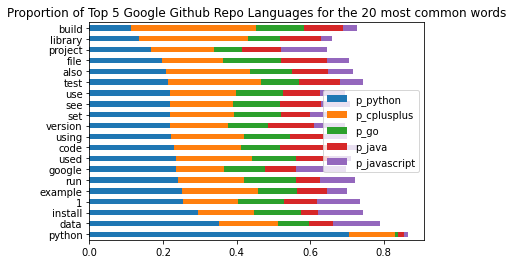

In [119]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_cplusplus=word_counts.cplusplus / word_counts['all'],
         p_go=word_counts.go / word_counts['all'],
         p_java=word_counts.java / word_counts['all'],
         p_javascript=word_counts.javascript / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_cplusplus', 'p_go', 'p_java', 'p_javascript']]
 .tail(20)
 .sort_values('p_python', ascending=False)
 .plot.barh(stacked=True))

plt.title('Proportion of Top 5 Google Github Repo Languages for the 20 most common words')

In [102]:
word_counts.head(2)

,python_freq,cplusplus_freq,go_freq,java_freq,javascript_freq,typescript_freq,dart_freq,c_freq,jupyternotebook_freq,html_freq,...,assembly_freq,makefile_freq,crystal_freq,emacslisp_freq,commonlisp_freq,powershell_freq,tex_freq,roff_freq,purebasic_freq,hcl_freq
0,119,125,60,27,34,7,3,33,16,0,...,1,0,5,0,0,0,0,0,0,0
00,12,10,1,1,0,0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# split

In [94]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = w.split(df, "language", "clean_content", 7890)

In [95]:
X_train.head()

805    certificate transparency go code build statush...
71     cabal2bazel tool help fetching cabal package h...
282    libsky130_fd_sc_hs sky130 high speed digital s...
551                                    mono_reporeadmemd
201    directed graph component angular modular compo...
Name: clean_content, dtype: object

# sklearn Model:
- make the thing
- fit the thing 
- use the thing


In [96]:
# Create the tfidf vectorizer object
tfidf = TfidfVectorizer()

# Fit on the training data
tfidf.fit(X_train)

# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

In [97]:
X_train_vectorized

<542x31917 sparse matrix of type '<class 'numpy.float64'>'
	with 102966 stored elements in Compressed Sparse Row format>

In [100]:
tfidfXtrain = pd.DataFrame(X_train_vectorized.todense(), columns=tfidf.get_feature_names())

In [120]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

fr

## Decision Tree Classifier


In [ ]:
# Make the thing
clf = DecisionTreeClassifier(max_depth=3, random_state=3210)
# Fit the thing
clf = clf.fit(X_train_vectorized, y_train)
# Use the thing
# Now we'll make a SET OF PREDICTIONS using this trained model
y_pred = clf.predict(X_train_vectorized)
# ESTIMATE THE PROBABLITIES for each class
y_pred_proba = clf.predict_proba(X_train_vectorized)